# ARGOS Simulator

E. Schrama

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from dsoclasses.argos_simulator.kepler_orbit import kepler_orbit
from dsoclasses.argos_simulator.rotate import rotate
from dsoclasses.argos_simulator.sph2xyz import sph2xyz
from dsoclasses.argos_simulator.generate import generate
from dsoclasses.argos_simulator.detect import detect
from dsoclasses.argos_simulator.mydoppler import mydoppler

Simulator assumes:

 Blat (deg)             50.00000000
 Blon (deg)              4.00000000
 f1   (MHz)                 433.000
 minelev  (deg)     10.0
 obs noise (Hz)     0.001
there are 6 passes


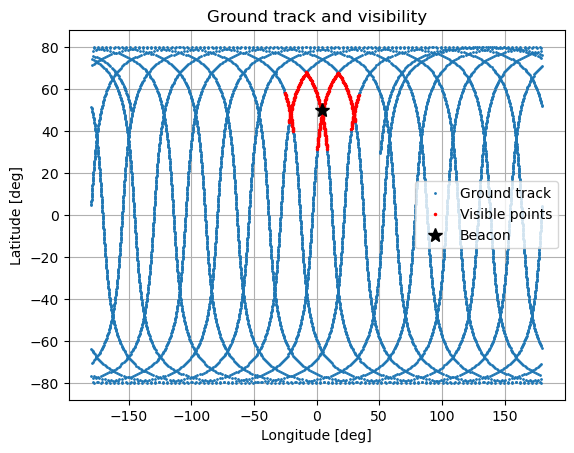

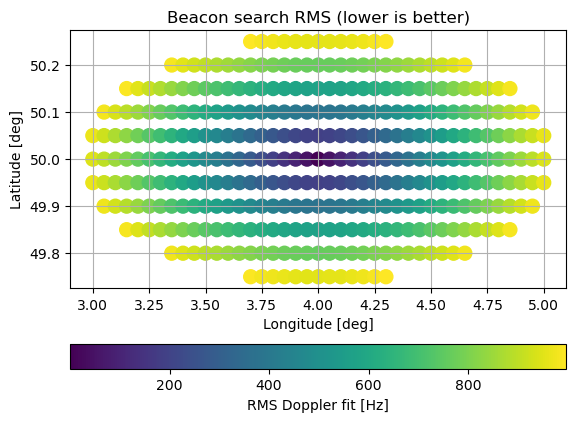

In [6]:
# Initial orbit elements & mission
ae = 6378137.0      # mean Earth radius [m]
major = 800e3 + ae  # semi-major axis [m]
eccen = 0.001
incli = np.deg2rad(80.0)
ranode = np.deg2rad(45.0)
omega = np.deg2rad(30.0)
gm = 3.986e14  # [m^3/s^2]
t0 = 0.0       # reference time [s]
nday = 1
t = np.arange(0.0, nday * 86400.0 + 1e-9, 10.0)  # 10 s steps
a0 = 0.0                                         # GAST at t0

# ECI orbit
pos_eci, vel_eci = kepler_orbit(major, eccen, incli, ranode, omega, t, t0, gm)

# Rotate to ECEF
pos_ecef, vel_ecef = rotate(t, pos_eci, vel_eci, t0, a0)

# Beacon & measurement settings
Blat = np.deg2rad(50.0)                   # beacon latitude (to recover)
Blon = np.deg2rad(4.0)                    # beacon longitude (to recover)
f0 = 433e6                                # nominal beacon freq [Hz]
rng = np.random.default_rng()             # reproducible? pass a seed if you like
f1 = f0 + (rng.random() * 2 - 1) * 100.0  # actual freq with small offset
minelev = np.deg2rad(10.0)                # min elevation at beacon
obs_noise = 1e-3                          # Hz

print("Simulator assumes:\n")
print(f" Blat (deg)         {np.rad2deg(Blat):15.8f}")
print(f" Blon (deg)         {np.rad2deg(Blon):15.8f}")
print(f" f1   (MHz)         {f1/1e6:15.3f}")
print(f" minelev  (deg)     {np.rad2deg(minelev)}")
print(f" obs noise (Hz)     {obs_noise}")

# Beacon to ECEF
xb, yb, zb = sph2xyz(ae, Blat, Blon)
beacon_xyz = np.array([xb, yb, zb])

# Generate “observed” doppler (noiseless first)
idx, time_obs, Dobs = generate(t, pos_ecef, vel_ecef, beacon_xyz, f1, minelev)

# Add noise
if time_obs.size > 0:
    Dobs = Dobs + (rng.random(size=time_obs.size) * 2 - 1) * obs_noise

# Ground track + visibility plot
lat_deg = np.degrees(
    np.arctan2(pos_ecef[:, 2], np.hypot(pos_ecef[:, 0], pos_ecef[:, 1]))
)
lon_deg = np.degrees(np.arctan2(pos_ecef[:, 1], pos_ecef[:, 0]))

plt.figure(1)
plt.clf()
plt.plot(lon_deg, lat_deg, ".", ms=2, label="Ground track")
if idx.size > 0:
    plt.plot(lon_deg[idx], lat_deg[idx], ".r", ms=3, label="Visible points")
plt.plot(np.degrees(Blon), np.degrees(Blat), "k*", ms=10, label="Beacon")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.title("Ground track and visibility")
plt.legend()
plt.grid(True)

# Detect contiguous passes
npass, pass_ids = detect(idx, time_obs, Dobs, maximum=20.0)
print(f"there are {npass} passes")

if npass == 0:
    print("No visible passes—try lowering minelev or running longer.")
    plt.show()
    # return
    raise ValueError("edit usepasses and re-run")

# Choose passes to use (all by default)
usepasses = np.arange(1, npass + 1, dtype=int)
if usepasses.max() > npass:
    raise ValueError("edit usepasses and re-run")

# Grid search over beacon lat/lon to evaluate Doppler fit RMS
xp, yp, zp = [], [], []
for LBlat in np.arange(45.0, 55.0 + 1e-12, 0.05):
    for LBlon in np.arange(3.0, 5.0 + 1e-12, 0.05):
        Blat_g = np.deg2rad(LBlat)
        Blon_g = np.deg2rad(LBlon)
        xb0, yb0, zb0 = sph2xyz(ae, Blat_g, Blon_g)
        beacon_guess = np.array([xb0, yb0, zb0])

        # Sum of squared residuals across passes, then RMS / #passes (matches MATLAB logic)
        rss = 0.0
        nrms = 0
        for p in usepasses:
            jdx = np.where(pass_ids == p)[0]
            if jdx.size == 0:
                continue
            # Important: idx/time/Dobs are already filtered to visible points; slice those
            Dcom = mydoppler(
                idx[jdx],
                time_obs[jdx],
                Dobs[jdx],
                t,
                pos_ecef,
                vel_ecef,
                beacon_guess,
                f1,
            )
            resid = Dobs[jdx] - Dcom
            rss += float(resid.T @ resid)
            nrms += 1

        if nrms == 0:
            continue
        rms = np.sqrt(rss / nrms)
        if rms < 1000:  # same guard as MATLAB
            xp.append(LBlon)
            yp.append(LBlat)
            zp.append(rms)

if len(xp) > 0:
    plt.figure(3)
    plt.clf()
    sc = plt.scatter(xp, yp, c=zp, s=100)
    plt.colorbar(sc, orientation="horizontal", label="RMS Doppler fit [Hz]")
    plt.xlabel("Longitude [deg]")
    plt.ylabel("Latitude [deg]")
    plt.title("Beacon search RMS (lower is better)")
    plt.grid(True)
else:
    print(
        "Grid search produced no RMS points under the threshold—consider widening the search box."
    )

plt.show()